In [1]:
%pip install opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 12.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

##  Visualize examples with the gt bounding boxes

In [38]:
# Directory path for the annotations
data_dir = "/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/Potholes/annotated-images"

def parse_ground_truth_boxes(data_dir):
    """
    Parse XML annotation files to create ground truth boxes for each image.
    """
    ground_truth_boxes = {}
    count_potholes = 0

    for xml_file in os.listdir(data_dir):
        if xml_file.endswith(".xml"):
            # Parse the XML file
            xml_path = os.path.join(data_dir, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Get image filename
            filename = root.find("filename").text

            #count number of potholes
            for obj in root.findall("object"):
                if obj.find("name").text == "pothole":
                    count_potholes += 1
            
            # Extract bounding boxes
            boxes = []
            for obj in root.findall("object"):
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)
                width = xmax - xmin
                height = ymax - ymin
                og_size = int (root.find("size").find("width").text), int(root.find("size").find("height").text)
                boxes.append({"x": xmin, "y": ymin, "width": width, "height": height, "original_size": og_size})
            
            # Add boxes to the dictionary with the filename as the key
            ground_truth_boxes[filename] = boxes
    
    print("Number of potholes in the dataset: ", count_potholes)
    return ground_truth_boxes

# Generate ground truth boxes dictionary
ground_truth_boxes = parse_ground_truth_boxes(data_dir)
print("Sample ground truth boxes:", list(ground_truth_boxes.items())[:5])


Number of potholes in the dataset:  1740
Sample ground truth boxes: [('img-621.jpg', [{'x': 198, 'y': 146, 'width': 42, 'height': 37, 'original_size': (303, 300)}, {'x': 7, 'y': 44, 'width': 107, 'height': 73, 'original_size': (303, 300)}, {'x': 1, 'y': 25, 'width': 48, 'height': 15, 'original_size': (303, 300)}, {'x': 147, 'y': 45, 'width': 67, 'height': 24, 'original_size': (303, 300)}, {'x': 224, 'y': 65, 'width': 63, 'height': 22, 'original_size': (303, 300)}, {'x': 3, 'y': 158, 'width': 42, 'height': 63, 'original_size': (303, 300)}]), ('img-577.jpg', [{'x': 37, 'y': 154, 'width': 198, 'height': 80, 'original_size': (480, 300)}, {'x': 104, 'y': 120, 'width': 37, 'height': 12, 'original_size': (480, 300)}, {'x': 35, 'y': 241, 'width': 61, 'height': 59, 'original_size': (480, 300)}, {'x': 274, 'y': 194, 'width': 68, 'height': 43, 'original_size': (480, 300)}, {'x': 313, 'y': 242, 'width': 41, 'height': 41, 'original_size': (480, 300)}, {'x': 361, 'y': 227, 'width': 58, 'height': 43,

In [26]:
# Directory path for both images and annotations
data_dir = "/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/Potholes/annotated-images"

def display_images_with_boxes(image_filenames, ground_truth_boxes, data_dir, figsize=(15, 5)):
    """
    Display images with bounding boxes in a single row using ground_truth_boxes.
    """
    plt.figure(figsize=figsize)
    num_images = len(image_filenames)
    
    for idx, filename in enumerate(image_filenames):
        image_path = os.path.join(data_dir, filename)
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get bounding boxes for this image from ground_truth_boxes
        boxes = ground_truth_boxes.get(filename, [])
        
        # Draw bounding boxes
        for box in boxes:
            x, y, width, height = box["x"], box["y"], box["width"], box["height"]
            cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)
        
        # Display image in the subplot
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(image)
        plt.axis("off")
    
    plt.show()


(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(300, 300, 3)


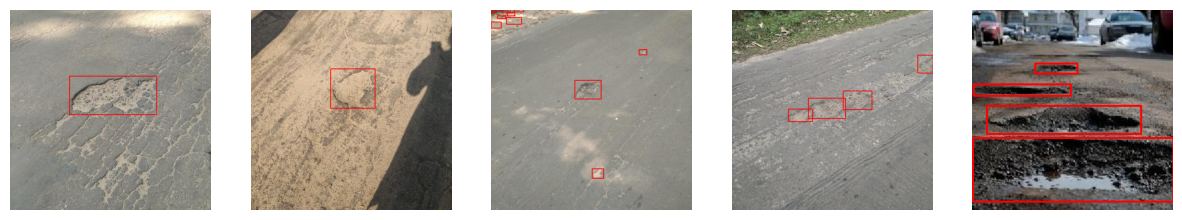

In [23]:
# Sample usage
# Select a few sample images to display
sample_image_filenames = ["img-1.jpg", "img-10.jpg", "img-184.jpg", "img-200.jpg", "img-300.jpg"]  # Add image names as needed
display_images_with_boxes(sample_image_filenames, ground_truth_boxes, data_dir)

## Extract object proposals for all the images

In [63]:
# Directory path for images
data_dir = "/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/Potholes/annotated-images"

# Parameters
resize_dim = (200, 200)  # Resize dimension for efficiency
proposal_limit = 2000000000000000000000000000000  # Limit number of proposals if needed

# Dictionary to store all proposals
all_proposals = {}

def selective_search_proposals(image, limit=None):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects[:limit] if limit else rects

def resize_image(image, dim):
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

def generate_proposals(data_dir, resize_dim=(400, 400), proposal_limit=200):
    total_images = 665  # Total number of images in the dataset
    for i in range(1, total_images + 1):
        image_file = f"img-{i}.jpg"
        print(f"Processing {image_file} ({i}/{total_images})")
        image_path = os.path.join(data_dir, image_file)
        
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            resized_image = resize_image(image, resize_dim)
            proposals = selective_search_proposals(resized_image, limit=proposal_limit)
            
            # Save proposals in the dictionary
            all_proposals[image_file] = [{"x": x, "y": y, "width": w, "height": h} for (x, y, w, h) in proposals]
        else:
            print(f"Image file {image_file} not found.")

def plot_image_with_proposals(image_file, proposals, data_dir, resize_dim=(400, 400)):
    """
    Plot an image with its proposals drawn as bounding boxes.
    """
    # Load and resize image
    image_path = os.path.join(data_dir, image_file)
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    
    # Draw each proposal as a rectangle
    for proposal in proposals:
        x, y, w, h = proposal["x"], proposal["y"], proposal["width"], proposal["height"]
        cv2.rectangle(resized_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    # Plot the image with proposals
    plt.figure(figsize=(6, 6))
    plt.imshow(resized_image)
    plt.axis("off")
    plt.title(f"Proposals for {image_file}")
    plt.show()


In [64]:
# Generate proposals and store them in the dictionary
generate_proposals(data_dir, resize_dim, proposal_limit)

Processing img-1.jpg (1/665)
Processing img-2.jpg (2/665)


Processing img-3.jpg (3/665)
Processing img-4.jpg (4/665)
Processing img-5.jpg (5/665)
Processing img-6.jpg (6/665)
Processing img-7.jpg (7/665)
Processing img-8.jpg (8/665)
Processing img-9.jpg (9/665)
Processing img-10.jpg (10/665)
Processing img-11.jpg (11/665)
Processing img-12.jpg (12/665)
Processing img-13.jpg (13/665)
Processing img-14.jpg (14/665)
Processing img-15.jpg (15/665)
Processing img-16.jpg (16/665)
Processing img-17.jpg (17/665)
Processing img-18.jpg (18/665)
Processing img-19.jpg (19/665)
Processing img-20.jpg (20/665)
Processing img-21.jpg (21/665)
Processing img-22.jpg (22/665)
Processing img-23.jpg (23/665)
Processing img-24.jpg (24/665)
Processing img-25.jpg (25/665)
Processing img-26.jpg (26/665)
Processing img-27.jpg (27/665)
Processing img-28.jpg (28/665)
Processing img-29.jpg (29/665)
Processing img-30.jpg (30/665)
Processing img-31.jpg (31/665)
Processing img-32.jpg (32/665)
Processing img-33.jpg (33/665)
Processing img-34.jpg (34/665)
Processing img-35.jpg 

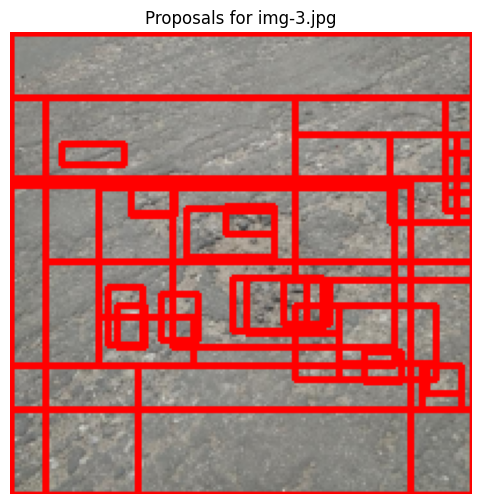

In [65]:
# Choose a random image from the proposals
random_image_file = 'img-3.jpg' # random.choice(list(all_proposals.keys()))
plot_image_with_proposals(random_image_file, all_proposals[random_image_file], data_dir, resize_dim)


## Evaluate the proposals - recall

In [66]:
import json

def calculate_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    """
    xA = max(boxA["x"], boxB["x"])
    yA = max(boxA["y"], boxB["y"])
    xB = min(boxA["x"] + boxA["width"], boxB["x"] + boxB["width"])
    yB = min(boxA["y"] + boxA["height"], boxB["y"] + boxB["height"])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both boxes
    boxAArea = boxA["width"] * boxA["height"]
    boxBArea = boxB["width"] * boxB["height"]

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [69]:
def evaluate_proposals(all_proposals, ground_truth_boxes, iou_threshold=0.5):
    """
    Evaluate proposals on the training set and calculate recall.
    """
    proposals_per_image = [5,50, 80, 85, 90, 100, 150, 200, 500, 1000,100000, 100000000000000000000]  # Adjusted proposal limits for datasets with fewer proposals per image
    results = {}

    for max_proposals in proposals_per_image:
        total_recall = 0
        
        # Evaluate recall across all images for this proposal limit
        for image_file, proposals in all_proposals.items():
            gt_boxes = ground_truth_boxes.get(image_file, [])
            matched_boxes = set()
            
            # Use only the available proposals if fewer than `max_proposals`
            limited_proposals = proposals[:max_proposals] if len(proposals) > max_proposals else proposals

            # Check each ground truth box for matches in proposals
            for gt in gt_boxes:
                for proposal in limited_proposals:
                    if calculate_iou(gt, proposal) >= iou_threshold:
                        matched_boxes.add(tuple(gt.items()))  # Track matched ground truth boxes
                        break  # Move to the next ground truth box if matched
            
            # Calculate recall for this image
            recall = len(matched_boxes) / len(gt_boxes) if gt_boxes else 0
            total_recall += recall

        # Calculate average recall across all images
        average_recall = total_recall / len(all_proposals) if all_proposals else 0
        results[max_proposals] = average_recall
        print(f"Max Proposals per Image: {max_proposals} - Average Recall: {average_recall:.2f}")

    return results

def show_matched_proposals(all_proposals, ground_truth_boxes, data_dir, iou_threshold=0.5, max_images=5):
    """
    Display images with proposals that have an IoU over the threshold with ground truth boxes, in a single row.
    """
    images_shown = 0  # Track the number of images displayed
    plt.figure(figsize=(15, 5))  # Set up figure for multiple images in a row
    
    for image_file, proposals in all_proposals.items():
        if images_shown >= max_images:
            break
        
        gt_boxes = ground_truth_boxes.get(image_file, [])
        matched_proposals = []

        # Identify matched proposals based on IoU
        for gt in gt_boxes:
            for proposal in proposals:
                if calculate_iou(gt, proposal) >= iou_threshold:
                    matched_proposals.append((gt, proposal))
                    break  # Only need one matching proposal per ground truth box
        
        if matched_proposals:
            print(f"Matched proposals for {image_file}: {len(matched_proposals)}")

        # Skip if no matches are found
        if not matched_proposals:
            continue
        
        # Load and process the image
        image_path = os.path.join(data_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Draw ground-truth boxes in green and proposals in red
        for gt, proposal in matched_proposals:
            # Draw ground-truth box (green)
            x, y, width, height = gt["x"], gt["y"], gt["width"], gt["height"]
            cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
            
            # Draw proposal box (red)
            px, py, pwidth, pheight = proposal["x"], proposal["y"], proposal["width"], proposal["height"]
            cv2.rectangle(image, (px, py), (px + pwidth, py + pheight), (255, 0, 0), 2)
        
        # Plot image in a subplot
        plt.subplot(1, max_images, images_shown + 1)
        plt.imshow(image)
        plt.title(f"{image_file} (IoU > {iou_threshold})")
        plt.axis("off")
        
        images_shown += 1  # Increment displayed images counter
    
    plt.tight_layout()
    plt.show()




Max Proposals per Image: 5 - Average Recall: 0.00
Max Proposals per Image: 50 - Average Recall: 0.01


Max Proposals per Image: 80 - Average Recall: 0.02
Max Proposals per Image: 85 - Average Recall: 0.02
Max Proposals per Image: 90 - Average Recall: 0.02
Max Proposals per Image: 100 - Average Recall: 0.02
Max Proposals per Image: 150 - Average Recall: 0.02
Max Proposals per Image: 200 - Average Recall: 0.02
Max Proposals per Image: 500 - Average Recall: 0.03
Max Proposals per Image: 1000 - Average Recall: 0.03
Max Proposals per Image: 100000 - Average Recall: 0.03
Max Proposals per Image: 100000000000000000000 - Average Recall: 0.03
Matched proposals for img-23.jpg: 1
Matched proposals for img-55.jpg: 1
Matched proposals for img-66.jpg: 1
Matched proposals for img-93.jpg: 1
Matched proposals for img-172.jpg: 1


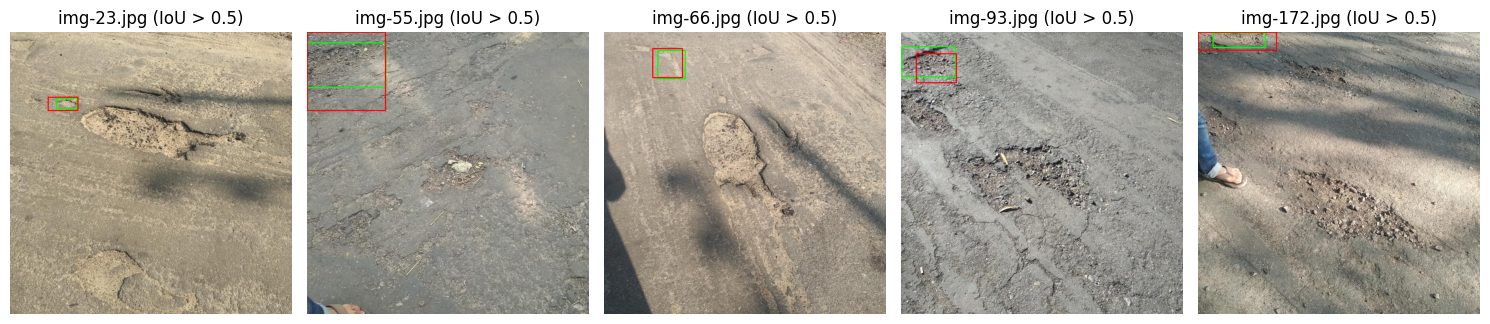

In [70]:
# Run the evaluation with specified maximum proposals per image
optimal_proposal_counts = evaluate_proposals(all_proposals, ground_truth_boxes)

# Example usage
show_matched_proposals(all_proposals, ground_truth_boxes, data_dir, iou_threshold=0.5, max_images=5)


**We choose 90 proposals per image**, as this gets the same average as 200

## Assign a label to the proposals

In [127]:
def prepare_proposals_for_training(all_proposals, ground_truth_boxes, iou_threshold=0.5, num_proposals=200, resize_dim=(200, 200)):
    """
    Prepare proposals for training by assigning a class label or background label to each proposal.
    
    Args:
        all_proposals (dict): Dictionary containing proposals for each image.
        ground_truth_boxes (dict): Dictionary containing ground truth boxes for each image, including original size.
        iou_threshold (float): IoU threshold to label a proposal as "pothole".
        num_proposals (int): Number of proposals to use per image.
        resize_dim (tuple): The dimensions to which images were resized during proposal generation.
    """
    labeled_proposals = {}  # Dictionary to store labeled proposals for each image

    for image_file, proposals in all_proposals.items():
        # Retrieve ground truth boxes and original size for scaling
        gt_boxes = ground_truth_boxes.get(image_file, [])
        
        if not gt_boxes:
            continue
        
        original_width, original_height = gt_boxes[0]["original_size"]  # Assume all ground truth boxes have the same original size
        
        # Calculate scaling factors based on the original and resized dimensions
        scale_x = original_width / resize_dim[0]
        scale_y = original_height / resize_dim[1]

        image_labeled_proposals = []

        for proposal in proposals[:num_proposals]:  # Limit to num_proposals proposals per image
            # Original proposal dimensions
            x_original = proposal["x"]
            y_original = proposal["y"]
            width_original = proposal["width"]
            height_original = proposal["height"]

            # Scale the proposal back to the original dimensions
            x_resized = int(x_original * scale_x)
            y_resized = int(y_original * scale_y)
            width_resized = int(width_original * scale_x)
            height_resized = int(height_original * scale_y)

            # Default label
            label = "background"

            # Check IoU with each ground truth box
            for gt in gt_boxes:
                if calculate_iou(gt, {"x": x_resized, "y": y_resized, "width": width_resized, "height": height_resized}) >= iou_threshold:
                    label = "pothole"
                    break  # Only need one ground truth match to label as pothole

            # Add labeled proposal with both original and resized dimensions
            image_labeled_proposals.append({
                "x_original": x_original,
                "y_original": y_original,
                "width_original": width_original,
                "height_original": height_original,
                "x_resized": x_resized,
                "y_resized": y_resized,
                "width_resized": width_resized,
                "height_resized": height_resized,
                "label": label,
                "original_size": (original_width, original_height),
                "final_size": resize_dim  # The final resized dimensions
            })

        # Store labeled proposals for this image
        labeled_proposals[image_file] = image_labeled_proposals

    return labeled_proposals


def save_proposals_to_json(labeled_proposals, output_file="labeled_proposals_resized.json"):
    """
    Save labeled proposals to a JSON file, ensuring all values are JSON-serializable.
    """
    # Convert all values to Python's native int type
    serializable_proposals = {}
    for image_file, proposals in labeled_proposals.items():
        serializable_proposals[image_file] = [
            {
                "x_original": int(p["x_original"]),
                "y_original": int(p["y_original"]),
                "width_original": int(p["width_original"]),
                "height_original": int(p["height_original"]),
                "x_resized": int(p["x_resized"]),
                "y_resized": int(p["y_resized"]),
                "width_resized": int(p["width_resized"]),
                "height_resized": int(p["height_resized"]),
                "label": p["label"],
                "original_size": (int(p["original_size"][0]), int(p["original_size"][1])),
                "final_size": (int(p["final_size"][0]), int(p["final_size"][1]))
            }            
            for p in proposals
        ]
    
    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(serializable_proposals, f, indent=4)
    print(f"Labeled proposals saved to {output_file}")


In [129]:
# Example usage
num_proposals = 90  # Number of proposals to consider per image

labeled_proposals = prepare_proposals_for_training(all_proposals, ground_truth_boxes, num_proposals=num_proposals, resize_dim=resize_dim)
print("Sample labeled proposals:", list(labeled_proposals.items())[:2])  # Display sample output

# Save the labeled proposals
save_proposals_to_json(labeled_proposals, output_file="/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/labeled_proposals_resized.json")

Sample labeled proposals: [('img-1.jpg', [{'x_original': np.int32(115), 'y_original': np.int32(15), 'width_original': np.int32(61), 'height_original': np.int32(3), 'x_resized': 414, 'y_resized': 54, 'width_resized': 219, 'height_resized': 10, 'label': 'background', 'original_size': (720, 720), 'final_size': (200, 200)}, {'x_original': np.int32(0), 'y_original': np.int32(71), 'width_original': np.int32(46), 'height_original': np.int32(33), 'x_resized': 0, 'y_resized': 255, 'width_resized': 165, 'height_resized': 118, 'label': 'background', 'original_size': (720, 720), 'final_size': (200, 200)}, {'x_original': np.int32(88), 'y_original': np.int32(145), 'width_original': np.int32(29), 'height_original': np.int32(43), 'x_resized': 316, 'y_resized': 522, 'width_resized': 104, 'height_resized': 154, 'label': 'background', 'original_size': (720, 720), 'final_size': (200, 200)}, {'x_original': np.int32(122), 'y_original': np.int32(79), 'width_original': np.int32(78), 'height_original': np.int3

In [118]:
import json
from collections import Counter

# Initialize a Counter to count each label
label_counts = Counter()

# Iterate over each image in the proposals
for image, bboxes in labeled_proposals.items():
    for bbox in bboxes:
        label = bbox['label']
        label_counts[label] += 1

# Print the class counts and class imbalance
total_labels = sum(label_counts.values())
print("Class Counts:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count / total_labels * 100:.2f}%)")

# Check class imbalance
print("\nClass Imbalance Summary:")
if len(label_counts) > 1:
    imbalance_ratio = max(label_counts.values()) / min(label_counts.values())
    print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
else:
    print("Only one class present; no imbalance.")

Class Counts:
background: 52000 (93.93%)
pothole: 3359 (6.07%)

Class Imbalance Summary:
Imbalance Ratio (max/min): 15.48


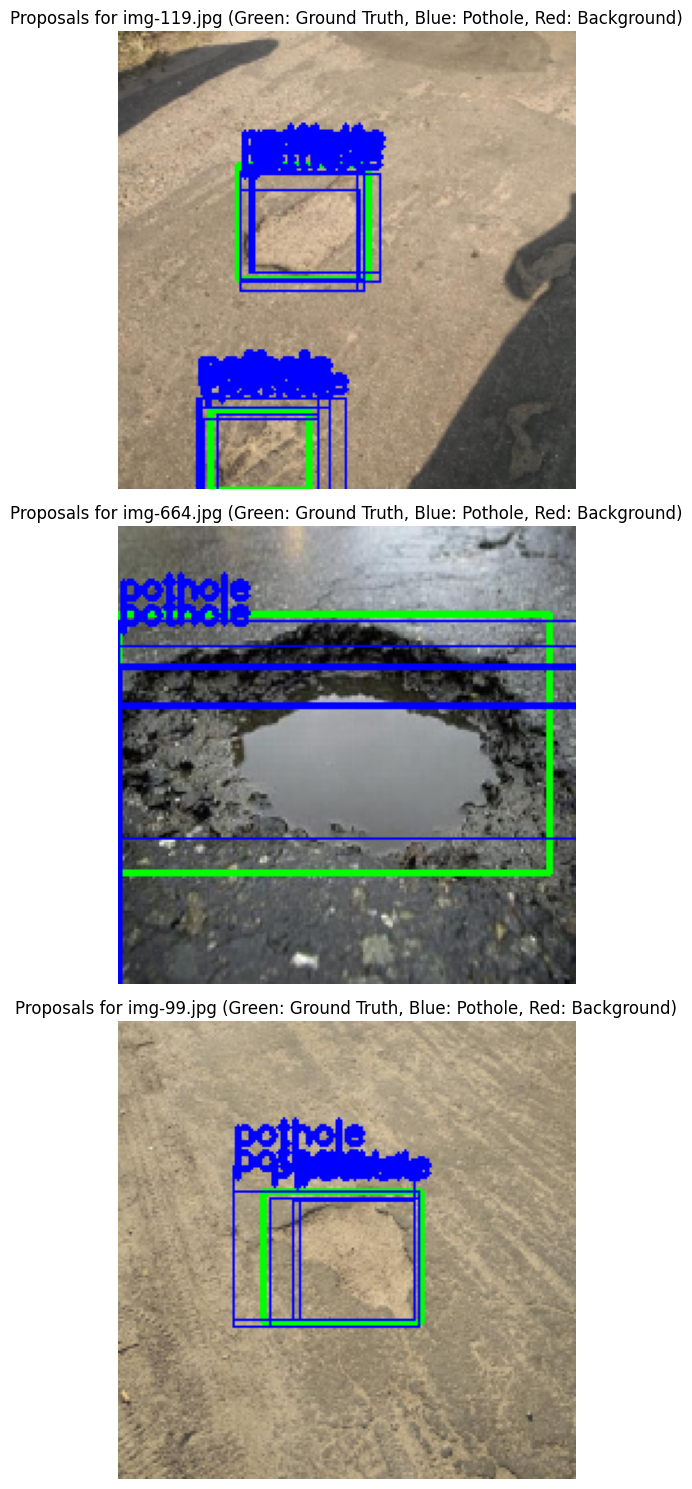

In [124]:
import matplotlib.pyplot as plt
import random
import cv2

def plot_labeled_proposals_with_resized_boxes(labeled_proposals, data_dir, ground_truth_boxes, num_images=3, resize_dim=(200, 200)):
    """
    Plot a few images with labeled proposals (both original and resized boxes) and ground truth boxes.
    
    Args:
        labeled_proposals (dict): Dictionary containing labeled proposals for each image.
        data_dir (str): Directory where images are stored.
        ground_truth_boxes (dict): Dictionary containing ground truth boxes for each image.
        num_images (int): Number of images to plot.
        resize_dim (tuple): The dimensions to which images were resized during proposal generation.
    """
    # Select a random sample of images to plot
    selected_images = random.sample(list(labeled_proposals.keys()), num_images)

    plt.figure(figsize=(15, 5 * num_images))
    
    for idx, image_file in enumerate(selected_images):
        # Load image and resize for visualization
        image_path = os.path.join(data_dir, image_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image {image_file} not found.")
            continue

        resized_image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting

        # Plot ground truth boxes in green on the resized image
        for gt in ground_truth_boxes.get(image_file, []):
            x, y, width, height = gt["x"], gt["y"], gt["width"], gt["height"]
            scale_x = resize_dim[0] / gt["original_size"][0]
            scale_y = resize_dim[1] / gt["original_size"][1]
            cv2.rectangle(resized_image, (int(x * scale_x), int(y * scale_y)), 
                          (int((x + width) * scale_x), int((y + height) * scale_y)), 
                          (0, 255, 0), 2)  # Green for ground truth

        # Plot labeled proposals with original and resized boxes
        for proposal in labeled_proposals[image_file]:
            # Use blue for potholes and red for background proposals
            color = (0, 0, 255) if proposal["label"] == "pothole" else (255, 0, 0)

            if proposal["label"] == "pothole":            
                # Plot the resized box
                cv2.rectangle(resized_image, (proposal["x_original"], proposal["y_original"]),
                                (proposal["x_original"] + proposal["width_original"],
                                proposal["y_original"] + proposal["height_original"]), color, 1)
                label_text = "pothole" if proposal["label"] == "pothole" else "background"
                cv2.putText(resized_image, label_text, 
                            (proposal["x_original"], proposal["y_original"] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
                # Plot the original box scaled to the resized image size
                cv2.rectangle(resized_image, (proposal["x_resized"], proposal["y_resized"]),
                                (proposal["x_resized"] + proposal["width_resized"], 
                                proposal["y_resized"] + proposal["height_resized"]), color, 2)

        # Display the image
        plt.subplot(num_images, 1, idx + 1)
        plt.imshow(resized_image)
        plt.title(f"Proposals for {image_file} (Green: Ground Truth, Blue: Pothole, Red: Background)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Usage example
plot_labeled_proposals_with_resized_boxes(labeled_proposals, data_dir, ground_truth_boxes, num_images=3, resize_dim=resize_dim)
